In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [2]:
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')

# Load the dataset
df = pd.read_csv('coffee_sales.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Preview the dataset
display(df.head())
df.info()


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1133 non-null   object 
 1   datetime     1133 non-null   object 
 2   cash_type    1133 non-null   object 
 3   card         1044 non-null   object 
 4   money        1133 non-null   float64
 5   coffee_name  1133 non-null   object 
dtypes: float64(1), object(5)
memory usage: 53.2+ KB


In [3]:
# Clean and transform data
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()
df['month'] = df['datetime'].dt.to_period('M')

#Checking Duplicate Data
df.duplicated().sum()

np.int64(0)

In [4]:
# Check for missing values
print(df.isnull().sum())

date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
hour            0
day_of_week     0
month           0
dtype: int64


In [5]:
# Fill missing values in 'card'
df['card'].fillna('CASH_PAYMENT', inplace=True)
print(df.isnull().sum())

date           0
datetime       0
cash_type      0
card           0
money          0
coffee_name    0
hour           0
day_of_week    0
month          0
dtype: int64


In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1133,2024-05-19 11:36:29.232127232,2024-03-01 00:00:00,2024-04-14 00:00:00,2024-05-23 00:00:00,2024-06-22 00:00:00,2024-07-31 00:00:00,NaN
datetime,1133,2024-05-20 02:38:39.053382912,2024-03-01 10:15:50.520000,2024-04-14 10:55:27.406000128,2024-05-23 12:22:06.604999936,2024-06-22 08:39:50.272999936,2024-07-31 21:55:16.570000,NaN
money,1133.0,33.105808,18.12,28.9,32.82,37.72,40.0,5.035366
hour,1133.0,14.552515,7.0,11.0,14.0,18.0,22.0,4.084588


In [7]:
df.loc[:,['cash_type','card','coffee_name']].describe().T

,count,unique,top,freq
cash_type,1133,2,card,1044
card,1133,447,CASH_PAYMENT,89
coffee_name,1133,8,Americano with Milk,268


In [8]:
df['cash_type'].value_counts(normalize=True)

cash_type
card    0.921447
cash    0.078553
Name: proportion, dtype: float64

In [9]:
pd.DataFrame(df['coffee_name'].value_counts(normalize=True).sort_values(ascending=False).round(4)*100)

,proportion
coffee_name,
Americano with Milk,23.65
Latte,21.45
Cappuccino,17.30
Americano,14.92
Cortado,8.74
Hot Chocolate,6.53
Espresso,4.32
Cocoa,3.09


In [10]:
print("Duration of Dataset")
[df['date'].min(),df['date'].max()]

Duration of Dataset


[Timestamp('2024-03-01 00:00:00'), Timestamp('2024-07-31 00:00:00')]

In [11]:
# Feature Engineering
df['is_cash'] = df['cash_type'].apply(lambda x: 1 if x.lower() == 'cash' else 0)
df['product'] = df['coffee_name'].str.lower().str.strip()

# Revenue aggregation
df_grouped = df.groupby(['date', 'product']).agg({'money': 'sum'}).reset_index()
df_pivot = df_grouped.pivot(index='date', columns='product', values='money').fillna(0)

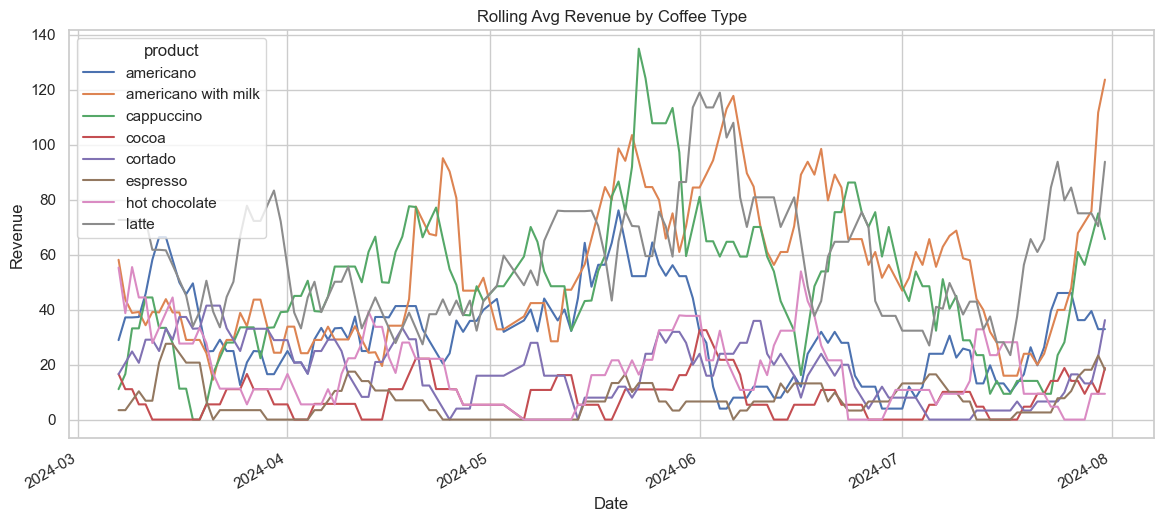

In [12]:
# Plot: Sales by Product Over Time
plt.figure(figsize=(14,6))
df_pivot.rolling(7).mean().plot(ax=plt.gca())
plt.title("Rolling Avg Revenue by Coffee Type")
plt.ylabel("Revenue")
plt.xlabel("Date")
plt.show()

Text(0.5, 0, 'Revenue')

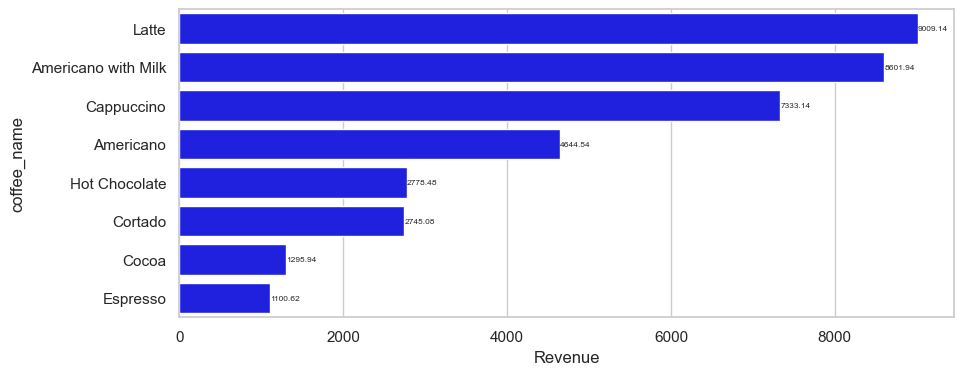

In [15]:
# Plot: bar graph Revenue vs coffee_type
revenue_data = df.groupby(['coffee_name']).sum(['money']).reset_index ().sort_values(by='money',ascending=False)
plt.figure(figsize=(10,4))
ax = sns.barplot(data=revenue_data,x='money',y='coffee_name',color='blue')
ax.bar_label(ax.containers[0], fontsize=6)
plt.xlabel('Revenue')


In [16]:
monthly_sales = df.groupby(['coffee_name','month']).count()['date'].reset_index().rename(columns={'date':'count'}).pivot(index='month',columns='coffee_name',values='count').reset_index()
monthly_sales.describe().T.loc[:,['min','max']]


,min,max
coffee_name,,
Americano,14.0,48.0
Americano with Milk,34.0,69.0
Cappuccino,20.0,55.0
Cocoa,5.0,9.0
Cortado,14.0,30.0
Espresso,7.0,14.0
Hot Chocolate,11.0,22.0
Latte,31.0,58.0


([<matplotlib.axis.XTick at 0x1da8f731690>,
 [Text(0, 0, 'Sun'),
  Text(1, 0, 'Mon'),
  Text(2, 0, 'Tue'),
  Text(3, 0, 'Wed'),
  Text(4, 0, 'Thur'),
  Text(5, 0, 'Fri'),
  Text(6, 0, 'Sat')])

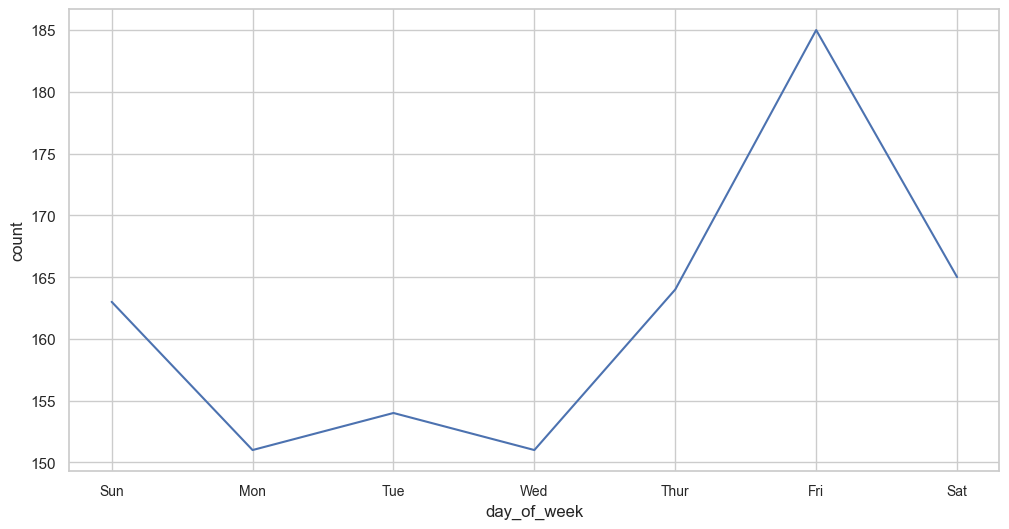

In [17]:
weekday_sales = df.groupby(['day_of_week']).count()['date'].reset_index().rename(columns={'date':'count'})
plt.figure(figsize=(12,6))
sns.lineplot(data=weekday_sales,x='day_of_week',y='count')
plt.xticks(range(len(weekday_sales['day_of_week'])),['Sun','Mon','Tue','Wed','Thur','Fri','Sat'],size='small')

In [18]:
daily_sales = df.groupby(['coffee_name','date']).count()['datetime'].reset_index().reset_index().rename(columns={'datetime':'count'}).pivot(index='date',columns='coffee_name',values='count').reset_index().fillna(0)
daily_sales.iloc[:,1:].describe().T.loc[:,['min','max']]

,min,max
coffee_name,,
Americano,0.0,5.0
Americano with Milk,0.0,12.0
Cappuccino,0.0,9.0
Cocoa,0.0,2.0
Cortado,0.0,4.0
Espresso,0.0,4.0
Hot Chocolate,0.0,4.0
Latte,0.0,7.0


<Axes: xlabel='hour', ylabel='count'>

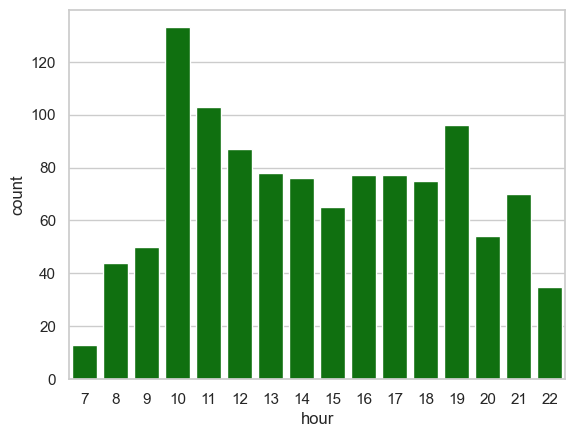

In [19]:
hourly_sales =df.groupby(['hour']).count()['date'].reset_index().rename(columns={'date':'count'})
sns.barplot(data=hourly_sales,x='hour',y='count',color='green')

11:43:32 - cmdstanpy - INFO - Chain [1] start processing
11:43:37 - cmdstanpy - INFO - Chain [1] done processing


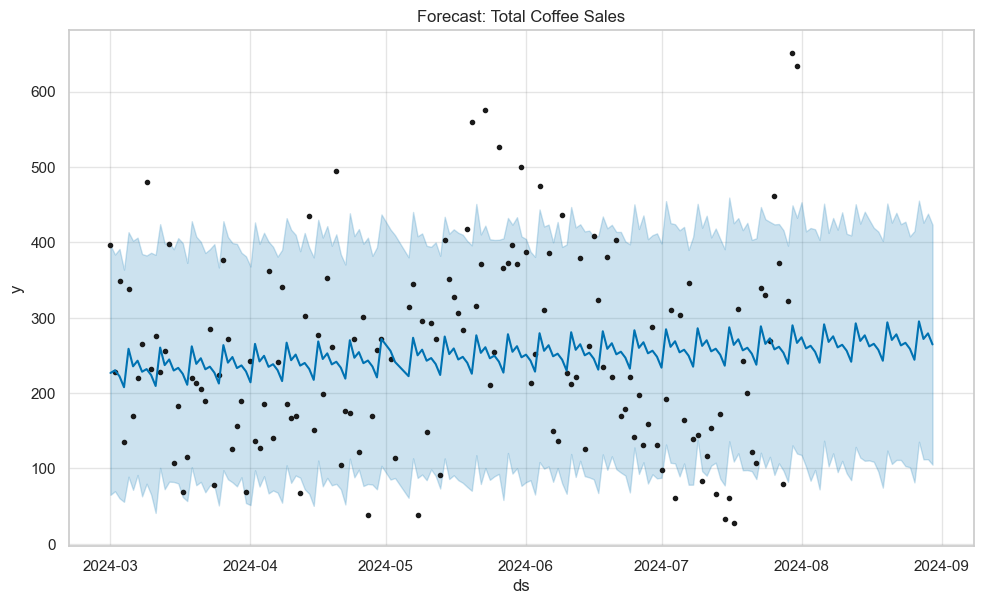

In [20]:
# Forecasting with Prophet - Total Sales
prophet_df = df.groupby('date')['money'].sum().reset_index()
prophet_df.columns = ['ds', 'y']
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)
plt.title("Forecast: Total Coffee Sales")
plt.show()

In [21]:
# Customer Insights
customer_df = df.groupby('card').agg(
    total_spent=('money', 'sum'),
    visits=('card', 'count'),
    avg_per_visit=('money', 'mean'),
    variety=('product', 'nunique')
).reset_index()
print(customer_df.head())  # Preview of customer insights


                  card  total_spent  visits  avg_per_visit  variety
0  ANON-0000-0000-0001       646.14      17      38.008235        1
1  ANON-0000-0000-0002        77.40       2      38.700000        1
2  ANON-0000-0000-0003       651.96      23      28.346087        4
3  ANON-0000-0000-0004       289.50       9      32.166667        3
4  ANON-0000-0000-0005        33.80       1      33.800000        1


In [22]:
# KMeans Clustering
features = ['total_spent', 'visits', 'avg_per_visit', 'variety']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['segment'] = kmeans.fit_predict(X_scaled)
print(customer_df['segment'].value_counts())  # Number of customers in each segment
print(customer_df.head())  # Preview segmented customer data


segment
0    287
3    127
2     30
1      3
Name: count, dtype: int64
                  card  total_spent  visits  avg_per_visit  variety  segment
0  ANON-0000-0000-0001       646.14      17      38.008235        1        0
1  ANON-0000-0000-0002        77.40       2      38.700000        1        0
2  ANON-0000-0000-0003       651.96      23      28.346087        4        2
3  ANON-0000-0000-0004       289.50       9      32.166667        3        2
4  ANON-0000-0000-0005        33.80       1      33.800000        1        0


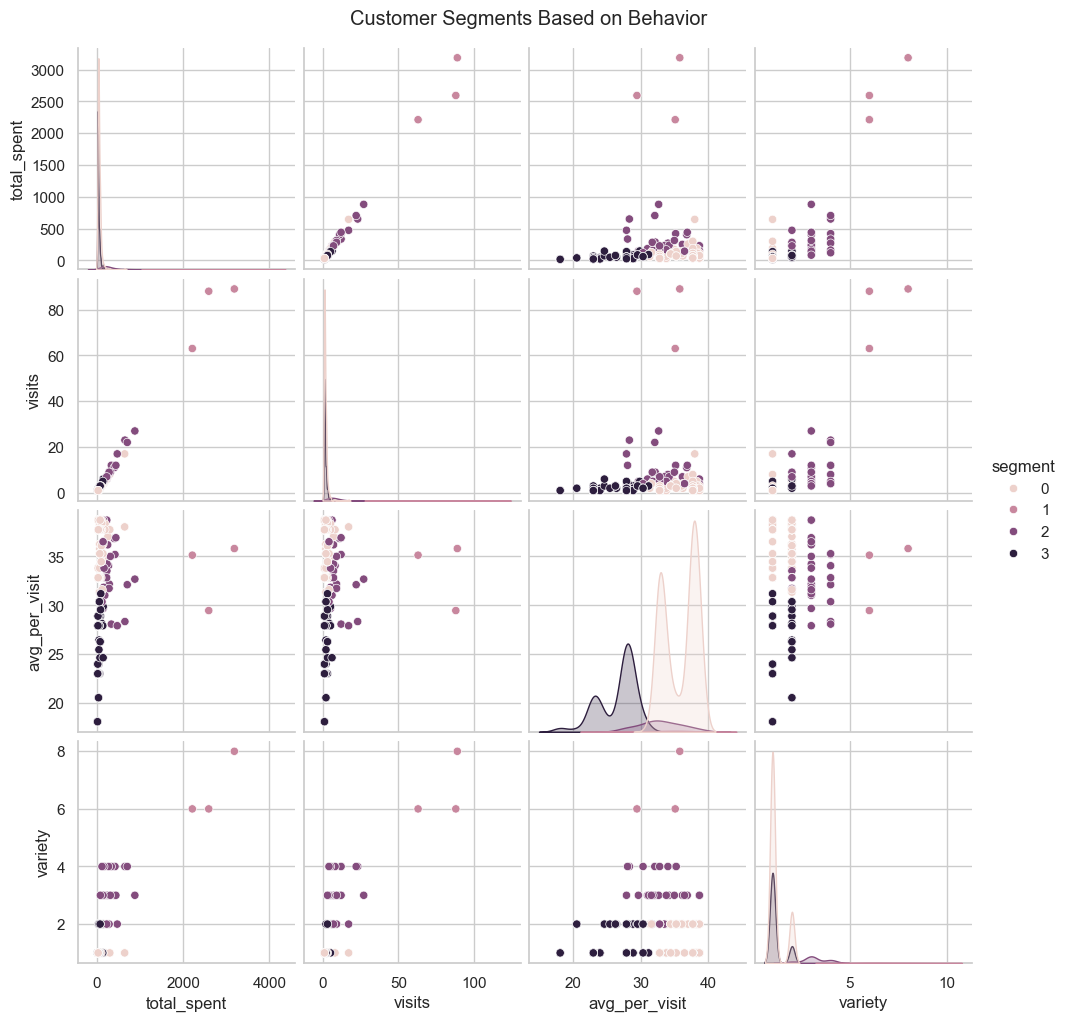

In [23]:
# Plot Customer Segments
sns.pairplot(customer_df, hue='segment', vars=features)
plt.suptitle("Customer Segments Based on Behavior", y=1.02)
plt.show()

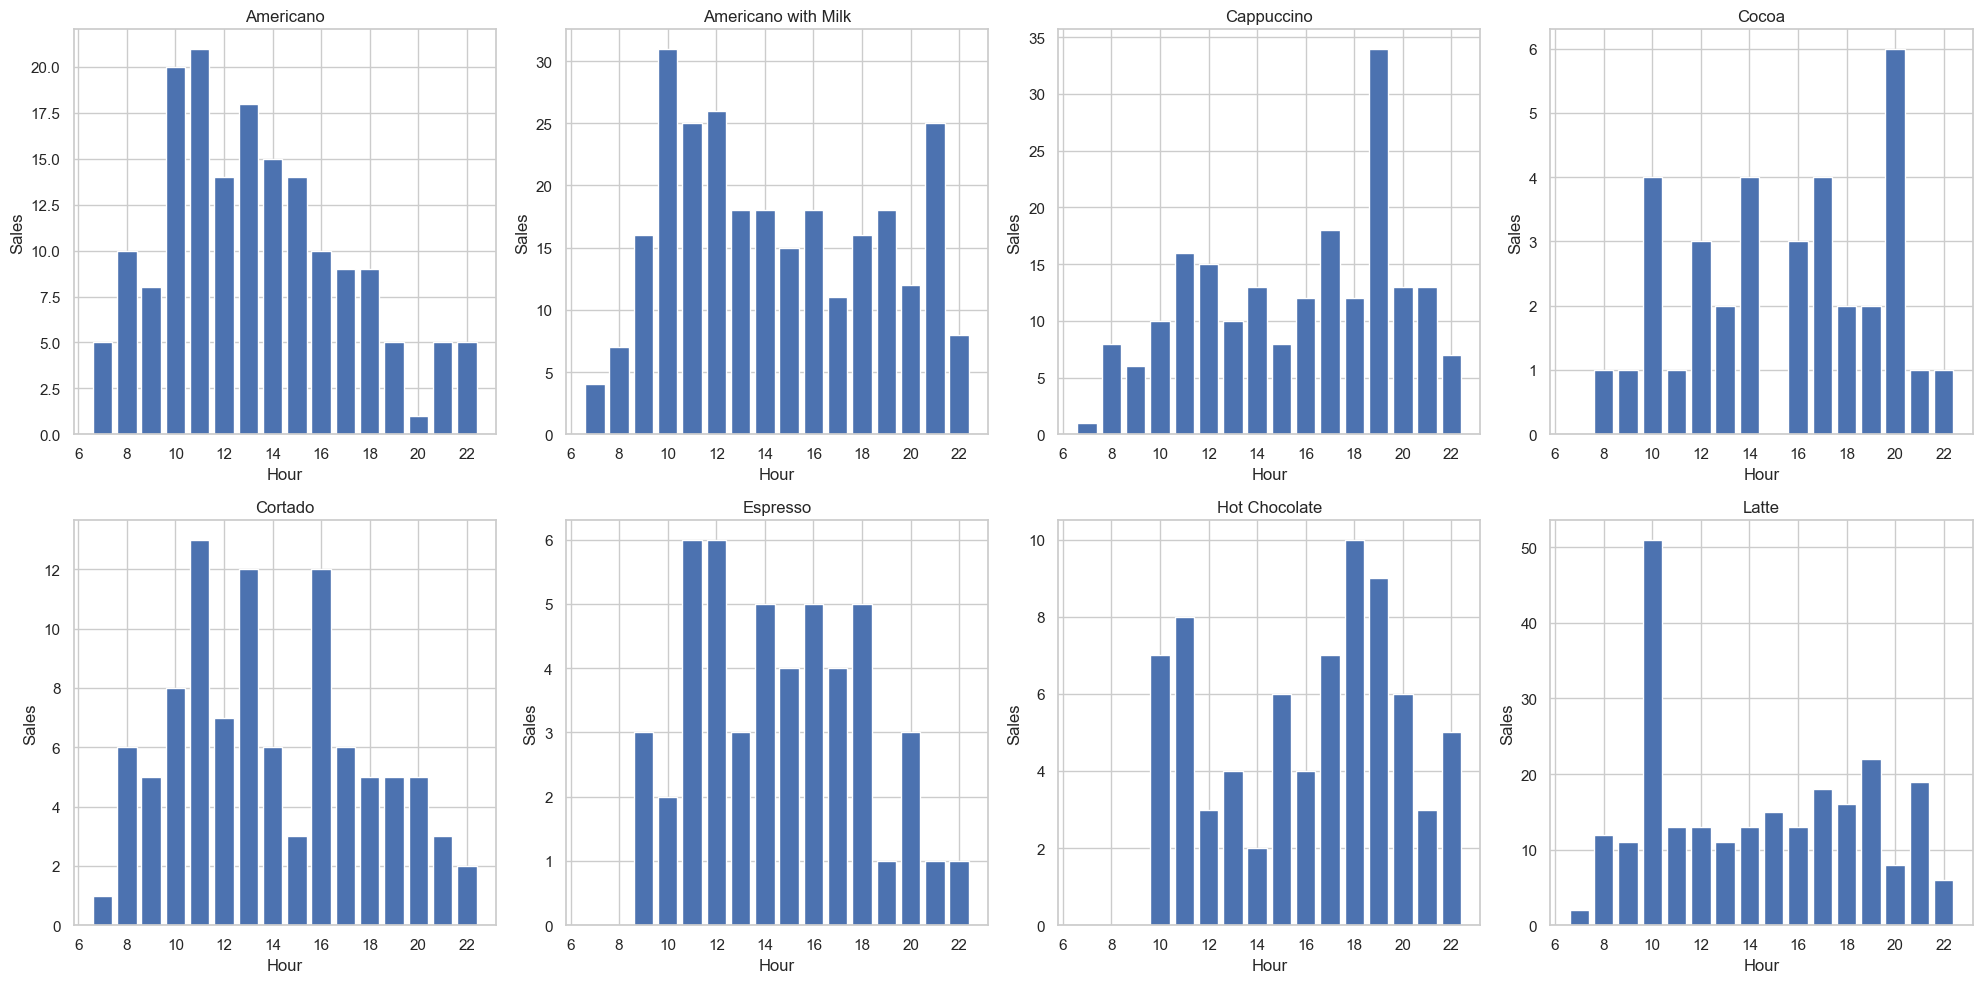

In [24]:
hourly_sales_by_coffee = df.groupby(['hour','coffee_name']).count()['date'].reset_index().rename(columns={'date':'count'}).pivot(index='hour', columns='coffee_name',values='count').fillna(0).reset_index()
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, column in enumerate(hourly_sales_by_coffee.columns[1:]):
    axs[i].bar(hourly_sales_by_coffee['hour'], hourly_sales_by_coffee[column])
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('Hour')
    axs[i].set_ylabel('Sales')
    

plt.tight_layout()
plt.show()

XGBoost RMSE: 149.06128740772684


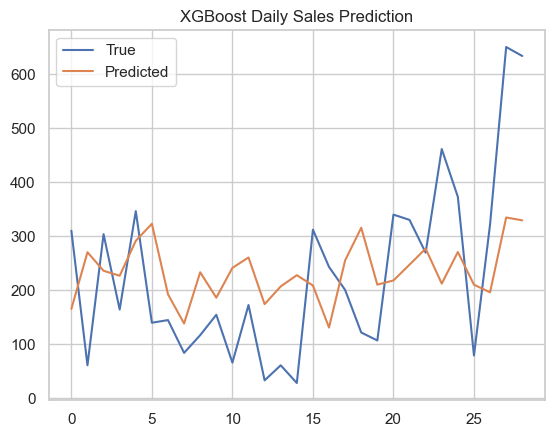

In [25]:
# Time Series Prediction with Machine Learning (XGBoost)
from xgboost import XGBRegressor

daily_sales = df.groupby('date').agg({'money': 'sum'}).reset_index()
daily_sales['day'] = daily_sales['date'].dt.dayofweek
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['lag_1'] = daily_sales['money'].shift(1)
daily_sales['lag_7'] = daily_sales['money'].shift(7)
daily_sales = daily_sales.dropna()

X = daily_sales[['day', 'month', 'lag_1', 'lag_7']]
y = daily_sales['money']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("XGBoost Daily Sales Prediction")
plt.show()

# Save prepared dataset
processed_df = df.copy()
processed_df.to_csv("processed_coffee_sales.csv", index=False)